In [1]:
import torch
import pickle
import time

import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import os
import networkx as nx
import numpy as np


D:\ana\envs\pytorch1.5\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import networkx as nx
import numpy as np


def build_graph(train_data):
    graph = nx.DiGraph()
    for seq in train_data:
        for i in range(len(seq) - 1):
            if graph.get_edge_data(seq[i], seq[i + 1]) is None:
                weight = 1
            else:
                weight = graph.get_edge_data(seq[i], seq[i + 1])['weight'] + 1
            graph.add_edge(seq[i], seq[i + 1], weight=weight)
    for node in graph.nodes:
        sum = 0
        for j, i in graph.in_edges(node):
            sum += graph.get_edge_data(j, i)['weight']
        if sum != 0:
            for j, i in graph.in_edges(i):
                graph.add_edge(j, i, weight=graph.get_edge_data(j, i)['weight'] / sum)
    return graph


def data_masks(all_usr_pois, item_tail):
    us_lens = [len(upois) for upois in all_usr_pois]
    len_max = max(us_lens)
    us_pois = [upois + item_tail * (len_max - le) for upois, le in zip(all_usr_pois, us_lens)]
    us_msks = [[1] * le + [0] * (len_max - le) for le in us_lens]
    return us_pois, us_msks, len_max


def split_validation(train_set, valid_portion):
    train_set_x, train_set_y = train_set
    n_samples = len(train_set_x)
    sidx = np.arange(n_samples, dtype='int32')
    np.random.shuffle(sidx)
    n_train = int(np.round(n_samples * (1. - valid_portion)))
    valid_set_x = [train_set_x[s] for s in sidx[n_train:]]
    valid_set_y = [train_set_y[s] for s in sidx[n_train:]]
    train_set_x = [train_set_x[s] for s in sidx[:n_train]]
    train_set_y = [train_set_y[s] for s in sidx[:n_train]]

    return (train_set_x, train_set_y), (valid_set_x, valid_set_y)


class Data():
    def __init__(self, data, shuffle=False, graph=None):
        inputs = data[0]
        inputs, mask, len_max = data_masks(inputs, [0])
        self.inputs = np.asarray(inputs)
        self.mask = np.asarray(mask)
        self.len_max = len_max
        self.targets = np.asarray(data[1])
        self.length = len(inputs)
        self.shuffle = shuffle
        self.graph = graph

    def generate_batch(self, batch_size):
        if self.shuffle:
            shuffled_arg = np.arange(self.length)
            np.random.shuffle(shuffled_arg)
            self.inputs = self.inputs[shuffled_arg]
            self.mask = self.mask[shuffled_arg]
            self.targets = self.targets[shuffled_arg]
        n_batch = int(self.length / batch_size)
        if self.length % batch_size != 0:
            n_batch += 1
        slices = np.split(np.arange(n_batch * batch_size), n_batch)
        slices[-1] = slices[-1][:(self.length - batch_size * (n_batch - 1))]
        # print("slices:")
        # print(slices)
        return slices

    def get_slice(self, i):
        inputs, mask, targets = self.inputs[i], self.mask[i], self.targets[i]
        items, n_node, A, alias_inputs = [], [], [], []
        print("inputs[0]_len：",len(inputs[0]))
        for u_input in inputs:
            n_node.append(len(np.unique(u_input)))
        max_n_node = np.max(n_node)
        for u_input in inputs:
            #np.uniqueP：对于一维数组或者列表，unique函数去除其中重复的元素，并按元素由大到小返回一个新的无元素重复的元组或者列表
            node = np.unique(u_input)
            # print("node:",node.shape)
            items.append(node.tolist() + (max_n_node - len(node)) * [0])
            u_A = np.zeros((max_n_node, max_n_node))
            for i in np.arange(len(u_input) - 1):
                if u_input[i + 1] == 0:
                    break
                u = np.where(node == u_input[i])[0][0]
                v = np.where(node == u_input[i + 1])[0][0]
                u_A[u][v] = 1
            u_sum_in = np.sum(u_A, 0)#在第0维进行求和（列求和，得到一行）
            u_sum_in[np.where(u_sum_in == 0)] = 1
            u_A_in = np.divide(u_A, u_sum_in)#除法运算，最后在u_A_in中数值范围0~1
            u_sum_out = np.sum(u_A, 1)
            u_sum_out[np.where(u_sum_out == 0)] = 1
            u_A_out = np.divide(u_A.transpose(), u_sum_out)
            u_A = np.concatenate([u_A_in, u_A_out]).transpose()
            A.append(u_A)
            alias_inputs.append([np.where(node == i)[0][0] for i in u_input]) #动作序列对应唯一动作集合的位置角标
        # print("A[0]:",A[0])
        # print("alias_inputs[0]:",alias_inputs[0])
        return alias_inputs, A, items, mask, targets

In [3]:
class Config():
    def __init__(self):
        self.batchsize = 20
        self.hiddensize = 10
        self.epochs = 10
        self.lr = 0.006
        self.lr_dc = 0.1
        self.lr_dc_step = 3
        self.l2 = 4e-4
        self.step = 1
        self.n_node = 310
        self.patience = 10
        self.nonhybrid = True
args = Config()

In [8]:
root_path = os.path.abspath('..')

In [10]:
train_data = pickle.load(open(root_path + '/data/train.txt', 'rb'))
test_data = pickle.load(open(root_path + '/data/test.txt', 'rb'))

In [11]:
train_data = Data(train_data, shuffle=True)
test_data = Data(test_data, shuffle=False)

In [12]:
import datetime
import math
import numpy as np
import torch
from torch import nn
from torch.nn import Module, Parameter
import torch.nn.functional as F


class GNN(Module):
    def __init__(self, hidden_size, step=1):
        super(GNN, self).__init__()
        #设置门控循环单元（GRU）所需参数
        self.step = step
        self.hidden_size = hidden_size
        self.input_size = hidden_size * 2
        self.gate_size = 3 * hidden_size
        #Parameter: 将一个不可训练的类型Tensor转换成可以训练的类型parameter并将这个parameter绑定到这个module里面以便进行优化
        self.w_ih = Parameter(torch.Tensor(self.gate_size, self.input_size))
        self.w_hh = Parameter(torch.Tensor(self.gate_size, self.hidden_size))
        self.b_ih = Parameter(torch.Tensor(self.gate_size))
        self.b_hh = Parameter(torch.Tensor(self.gate_size))
        self.b_iah = Parameter(torch.Tensor(self.hidden_size))
        self.b_oah = Parameter(torch.Tensor(self.hidden_size))
        #nn.Linear：对输入数据做线性变换 y=xA^T+b
        self.linear_edge_in = nn.Linear(self.hidden_size, self.hidden_size, bias=True)
        self.linear_edge_out = nn.Linear(self.hidden_size, self.hidden_size, bias=True)
        self.linear_edge_f = nn.Linear(self.hidden_size, self.hidden_size, bias=True)
        # print(self.linear_edge_in)
    '''
    形如 [:,:,:]的表达式常备用于python中的维度采样(https://so.csdn.net/so/search?from=pc_blog_highlight&q=python)
    '''
    '''
    GNNCell(self, A, hidden) #将节点的出入度邻接矩阵及隐层矩阵输入GNNCell（门控图神经网络神经元，
    在这个函数中基于nn.Linear的实现了门控循环单元的基本结构，执行论文中的更新函数[公式1-5]），
    GNNCell返回值用于更新hidden矩阵
    '''
    def GNNCell(self, A, hidden):
        # print("hidden:", hidden.shape)
        # print("self.linear_edge_in(hidden).shape:", self.linear_edge_in(hidden).shape)
        input_in = torch.matmul(A[:, :, :A.shape[1]], self.linear_edge_in(hidden)) + self.b_iah
        input_out = torch.matmul(A[:, :, A.shape[1]: 2 * A.shape[1]], self.linear_edge_out(hidden)) + self.b_oah
        inputs = torch.cat([input_in, input_out], 2)
        # print("gate_input_in:")
        # print(input_in.shape)
        # print("gate_input_out:")
        # print(input_out.shape)
        # print("gate_inputs:")
        # print(inputs.shape)
        gi = F.linear(inputs, self.w_ih, self.b_ih)
        gh = F.linear(hidden, self.w_hh, self.b_hh)
        # print(gi.shape)
        # print(gi.shape)
        i_r, i_i, i_n = gi.chunk(3, 2)
        # print(i_r.shape)
        h_r, h_i, h_n = gh.chunk(3, 2)
        # print(h_r.shape)
        resetgate = torch.sigmoid(i_r + h_r)#原文公式(3)
        inputgate = torch.sigmoid(i_i + h_i)#原文公式(2)
        newgate = torch.tanh(i_n + resetgate * h_n)#原文公式(4)
        hy = newgate + inputgate * (hidden - newgate)#原文公式(5)
        return hy
    '''
    当执行model(x)的时候，底层自动调用forward方法计算结果
    注：【model = Model,之后应该调用model(input_data),这里实际上执行的是model.call(input_data),
        而不应该调用model.forward(input_data) 】因为前者(即:model(input_data))会小心地处理并执行相关地注册登记好的钩子函数,
        然而后者(即:model.forward(input_data))仅仅静默地忽略掉这些钩子函数.
    '''
    def forward(self, A, hidden):
        # print("A(GNN):",A.shape)
        # print(hidden.shape)
        for i in range(self.step):
            hidden = self.GNNCell(A, hidden)
        return hidden


class SessionGraph(Module):
    def __init__(self, args):
        super(SessionGraph, self).__init__()
        self.hidden_size = args.hiddensize
        self.n_node = args.n_node
        self.batch_size = args.batchsize
        self.nonhybrid = args.nonhybrid
        # 定义词典的大小及维度
        self.embedding = nn.Embedding(self.n_node, self.hidden_size)
        self.gnn = GNN(self.hidden_size, step=args.step)
        self.linear_one = nn.Linear(self.hidden_size, self.hidden_size, bias=True)
        self.linear_two = nn.Linear(self.hidden_size, self.hidden_size, bias=True)
        self.linear_three = nn.Linear(self.hidden_size, 1, bias=False)
        self.linear_transform = nn.Linear(self.hidden_size * 2, self.hidden_size, bias=True)
        self.loss_function = nn.CrossEntropyLoss()
        #初始化优化器optimizer ，使用Adam优化算法，设置学习率及权重衰减
        self.optimizer = torch.optim.Adam(self.parameters(), lr=args.lr, weight_decay=args.l2)
        #初始化scheduler， 设置学习率更新策略，设置衰减程度及更新周期
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=args.lr_dc_step, gamma=args.lr_dc)
        self.reset_parameters()

    # 将权重矩阵初始化为（-√100，√100）间的数（100为隐层数）
    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def compute_scores(self, hidden, mask):
        # print("hidden:", hidden.shape)
        # hidden-->(100,16,100) 其中16代表现样本所有数据最长会话的长度，长度不足其余部分补了0
        # mask-->(100,16) 有序列的位置是[1],没有动作序列的位置是[0]
        # sum(mask, 1)：行求和，得到一列
        ht = hidden[torch.arange(mask.shape[0]).long(), torch.sum(mask, 1) - 1]  # batch_size x latent_size (100,100) 这是最后一个动作对应的位置，即文章中说的局部偏好
        # print("ht",torch.sum(mask, 1) - 1)
        q1 = self.linear_one(ht).view(ht.shape[0], 1, ht.shape[1])  # batch_size x 1 x latent_size (100,1,100) 局部偏好线性变换后改成能计算的维度
        q2 = self.linear_two(hidden)  # batch_size x seq_length x latent_size 即全局偏好
        alpha = self.linear_three(torch.sigmoid(q1 + q2))
        print("mask",mask[0])
        print("alpha:",alpha.shape)
        print("mask.view(mask.shape[0], -1, 1).shape",mask.view(mask.shape[0], -1, 1).shape)
        print("alpha * hidden * mask.view(mask.shape[0], -1, 1):", (alpha*hidden*mask.view(mask.shape[0], -1, 1).float()).shape)
        a = torch.sum(alpha * hidden * mask.view(mask.shape[0], -1, 1).float(), 1)#原文中公式(6)
        if not self.nonhybrid:
            a = self.linear_transform(torch.cat([a, ht], 1))#原文中公式(7)
        b = self.embedding.weight[1:]  # n_nodes x latent_size
        scores = torch.matmul(a, b.transpose(1, 0))#原文中公式(8)
        print('scores: ', scores.shape)
        return scores

    def forward(self, inputs, A):
        # print("A(SessionGraph):",A.shape)
        '''
        inputs: 行为不同的点击序列，行长为batchSize，列长度为当前batch中最长点击序列长度
        embedding：输出由input中每个序列中顶点向量构成的词典，向量长度即隐层数
        '''
        hidden = self.embedding(inputs)
        # print("inputs:")
        # print(inputs.shape)
        # print("hidden:")
        # print(hidden.shape)
        '''
        A: 在input的基础上增加一个长度为2*序列顶点数量的维度，储存各顶点的出入度
        hidden：隐藏层，储存顶点向量。hidden在input两个维度基础上增加了第三个维度，长度为hiddenSize。
        gnn：返回经论文中的更新函数更新后的hidden矩阵
        '''
        hidden = self.gnn(A, hidden)
        return hidden

#trans_to_cuda调用variable.cuda()表示用.cuda处理模型及相应数据
def trans_to_cuda(variable):
    if torch.cuda.is_available():
        return variable.cuda()
    else:
        return variable


def trans_to_cpu(variable):
    if torch.cuda.is_available():
        return variable.cpu()
    else:
        return variable


def forward(model, i, data):
    # get_slice返回：点击序列对应唯一动作集合的位置角标，该批数据图矩阵的列表，该batch的点击序列矩阵，mask矩阵，目标数据
    alias_inputs, A, items, mask, targets = data.get_slice(i)
    alias_inputs = trans_to_cuda(torch.Tensor(alias_inputs).long())
    # print('alias_inputs: ', alias_inputs.shape)
    # print("alias_inputs[0]:", alias_inputs[0])
    items = trans_to_cuda(torch.Tensor(items).long())
    A = trans_to_cuda(torch.Tensor(A).float())
    # print('A: ', A.shape)
    mask = trans_to_cuda(torch.Tensor(mask).long())
    hidden = model(items, A)  #这里调用了SessionGraph的forward函数,返回维度数目(100,>5,100)
    # print("hiddden",hidden.shape)
    #将get中的i替换为hidden[i][alias_inputs[i]](选择第这一批第i个样本对应类别序列的函数)
    get = lambda i: hidden[i][alias_inputs[i]]
    # print("hidden[0][alias_inputs[0]]:",hidden[0][alias_inputs[0]])
    # test_get = get(0)
    # print("get[0]:",test_get.shape)
    #torch.stack()同样是对tensors沿指定维度拼接，但返回的Tensor会多一维(形象的理解：假如数据都是二维矩阵(平面)，它可以把这些一个个平面按第三维(例如：时间序列)压成一个三维的立方体，而立方体的长度就是时间序列长度。)
    seq_hidden = torch.stack([get(i) for i in torch.arange(len(alias_inputs)).long()]) #(100,>16,100)
    # print('targets: ', len(targets))
    # print('items: ', items.shape)
    # print('mask: ', mask.shape)
    # 返回目标数据、每个候选项对应的分数
    return targets, model.compute_scores(seq_hidden, mask)


def train_test(model, train_data, test_data):
    model.scheduler.step()
    print('start training: ', datetime.datetime.now())
    model.train()
    total_loss = 0.0
    slices = train_data.generate_batch(model.batch_size)#函数定义于utils.py, 根据批的大小生成批数据的索引
    #zip() 函数用于将可迭代的对象作为参数，将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的列表
    for i, j in zip(slices, np.arange(len(slices))): #根据批的索引数据进行数据提取训练:i-->批索引, j-->第几批
        model.optimizer.zero_grad()
        targets, scores = forward(model, i, train_data)#传入模型model(SessionGraph), 数据批的索引i, 训练的数据data(Data);返回目标数据、每个候选项对应的分数
        targets = trans_to_cuda(torch.Tensor(targets).long())
        print("targets",targets.shape)
        # print("targets", targets)
        print("scores", scores.shape)
        # 得到loss并进行反向传播更新参数
        loss = model.loss_function(scores, targets - 1)
        loss.backward()

        model.optimizer.step()
        total_loss += loss #累加当前batch的loss
        if j % int(len(slices) / 5 + 1) == 0:
            # print('slices: ', slices)
            print('[%d/%d] Loss: %.4f' % (j, len(slices), loss.item()))
    print('\tLoss:\t%.3f' % total_loss)

    print('start predicting: ', datetime.datetime.now())
    model.eval()
    hit, mrr = [], []
    slices = test_data.generate_batch(model.batch_size) #根据测试集大小生成批数据索引
    for i in slices: # i-->批索引
        targets, scores = forward(model, i, test_data)
        sub_scores = scores.topk(20)[1]
        sub_scores = trans_to_cpu(sub_scores).detach().numpy()
        for score, target, mask in zip(sub_scores, targets, test_data.mask):
            #np.isin(a,b) 用于判定a中的元素在b中是否出现过，如果出现过返回True,否则返回False,最终结果为一个形状和a一模一样的数组（bool类型）。
            hit.append(np.isin(target - 1, score))
            if len(np.where(score == target - 1)[0]) == 0:
                mrr.append(0)
            else:
                # MRR是一个国际上通用的对搜索算法进行评价的机制，即第一个结果匹配，分数为1，第二个匹配分数为0.5，第n个匹配分数为1/n，如果没有匹配的句子分数为0。最终的分数为所有得分之和。
                mrr.append(1 / (np.where(score == target - 1)[0][0] + 1))
    # mean（）：对矩阵中m*n 个数求均值，返回一个实数
    hit = np.mean(hit) * 100
    mrr = np.mean(mrr) * 100
    return hit, mrr

In [13]:
model = trans_to_cuda(SessionGraph(args))

In [14]:
def forward(model, i, data):
    alias_inputs, A, items, mask, targets = data.get_slice(i)
    alias_inputs = trans_to_cuda(torch.Tensor(alias_inputs).long())
    items = trans_to_cuda(torch.Tensor(items).long())
    A = trans_to_cuda(torch.Tensor(A).float())
    mask = trans_to_cuda(torch.Tensor(mask).long())
    hidden = model(items, A)
    get = lambda i: hidden[i][alias_inputs[i]]
    seq_hidden = torch.stack([get(i) for i in torch.arange(len(alias_inputs)).long()])
    return targets, model.compute_scores(seq_hidden, mask)

In [15]:
def train_test(model, train_data, test_data):
    model.scheduler.step()
    print('start training: ', datetime.datetime.now())
    model.train()
    total_loss = 0.0
    slices = train_data.generate_batch(model.batch_size)
    for i, j in zip(slices, np.arange(len(slices))):
        model.optimizer.zero_grad()
        targets, scores = forward(model, i, train_data)
        targets = trans_to_cuda(torch.Tensor(targets).long())
        loss = model.loss_function(scores, targets - 1)
        loss.backward()
        model.optimizer.step()
        total_loss += loss
        if j % int(len(slices) / 5 + 1) == 0:
            print('[%d/%d] Loss: %.4f' % (j, len(slices), loss.item()))
    print('\tLoss:\t%.3f' % total_loss)

    print('start predicting: ', datetime.datetime.now())
    model.eval()
    hit, mrr = [], []
    slices = test_data.generate_batch(model.batch_size)
    for i in slices:
        targets, scores = forward(model, i, test_data)
        sub_scores = scores.topk(20)[1]
        sub_scores = trans_to_cpu(sub_scores).detach().numpy()
        for score, target, mask in zip(sub_scores, targets, test_data.mask):
            hit.append(np.isin(target - 1, score))
            if len(np.where(score == target - 1)[0]) == 0:
                mrr.append(0)
            else:
                mrr.append(1 / (np.where(score == target - 1)[0][0] + 1))
    hit = np.mean(hit) * 100
    mrr = np.mean(mrr) * 100
    return hit, mrr, total_loss


In [16]:
start = time.time()
best_result = [0, 0]
best_epoch = [0, 0]
bad_counter = 0
Loss, Hit, Mrr = [], [], []
Time = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
with open('../work/' + Time + '.log', 'w') as f:
    for epoch in range(args.epochs):
        print('-------------------------------------------------------')
        print('epoch: ', epoch)
        f.write('epoch: {}\n'.format(epoch))
        hit, mrr, loss = train_test(model, train_data, test_data)
        Loss.append(loss.item()), Hit.append(hit), Mrr.append(mrr)
        flag = 0
        if hit >= best_result[0]:
            best_result[0] = hit
            best_epoch[0] = epoch
            flag = 1
        if mrr >= best_result[1]:
            best_result[1] = mrr
            best_epoch[1] = epoch
            flag = 1
        print('Best Result:')
        print('\tRecall@20:\t%.4f\tMMR@20:\t%.4f\tEpoch:\t%d,\t%d'% (best_result[0], best_result[1], best_epoch[0], best_epoch[1]))
        f.write('Best Result:\n')
        f.write('\t\tRecall@20:\t%.4f\tMMR@20:\t%.4f\tEpoch:\t%d,\t%d\n'% (best_result[0], best_result[1], best_epoch[0], best_epoch[1]))
        bad_counter += 1 - flag
        if bad_counter >= args.patience:
            break
    print('-------------------------------------------------------')
    end = time.time()
    print("Run time: %f s" % (end - start))

-------------------------------------------------------
epoch:  0
start training:  2023-02-13 18:47:44.165137


D:\ana\envs\pytorch1.5\lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


inputs[0]_len： 16


D:\ana\envs\pytorch1.5\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  """


mask tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
alpha: torch.Size([20, 16, 1])
mask.view(mask.shape[0], -1, 1).shape torch.Size([20, 16, 1])
alpha * hidden * mask.view(mask.shape[0], -1, 1): torch.Size([20, 16, 10])
scores:  torch.Size([20, 309])
[0/61] Loss: 5.7304
inputs[0]_len： 16
mask tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
alpha: torch.Size([20, 16, 1])
mask.view(mask.shape[0], -1, 1).shape torch.Size([20, 16, 1])
alpha * hidden * mask.view(mask.shape[0], -1, 1): torch.Size([20, 16, 10])
scores:  torch.Size([20, 309])
inputs[0]_len： 16
mask tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0])
alpha: torch.Size([20, 16, 1])
mask.view(mask.shape[0], -1, 1).shape torch.Size([20, 16, 1])
alpha * hidden * mask.view(mask.shape[0], -1, 1): torch.Size([20, 16, 10])
scores:  torch.Size([20, 309])
inputs[0]_len： 16
mask tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])
alpha: torch.Size([20, 16, 1])
mask.view(mask.shape[0], -1, 1).shape torch.Size([

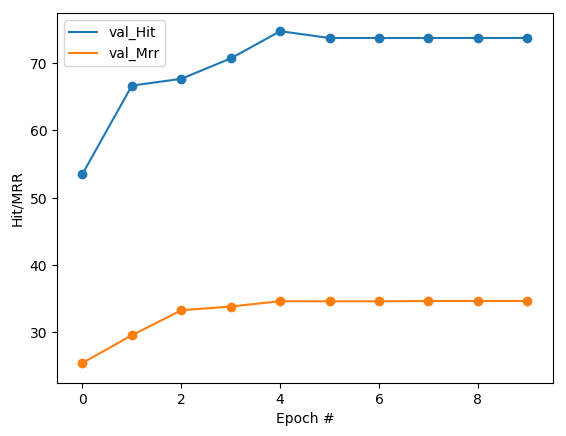

In [17]:
plt.figure()  # 初始化画布
x1 = range(0, args.epochs) # 取横坐标的值
plt.plot(x1, Hit, label='val_Hit')  # 绘制折线图
plt.scatter(x1, Hit)  # 绘制散点图
plt.plot(x1, Mrr, label='val_Mrr')
plt.scatter(x1, Mrr)  
plt.xlabel('Epoch #')  # 设置坐标轴名称
plt.ylabel('Hit/MRR')
plt.legend()
plt.show() # 显示图片